In this module we will explore planning of process chains using AI-based approaches. The problem we are looking at is the flexible job shop problem. Here, jobs and their associated operations must be assigned to the available machines in order to minimize throughput time. Traditionally, this is done using priority rules. AI-based approaches include the use of reinforcement learning or genetic algorithms. In this module, we will use genetic algorithms (GA) to solve the problem.

First, we define a scenario with various machines, jobs and related tasks. Each task has restrictions on the machines on which it can be performed. Task durations are generated randomly.

In [50]:
import pygad
import simpy
import random

# Simulation parameters
NUM_MACHINES = 6  # Number of machines in the shop
NUM_JOBS = 5      # Number of jobs
TASKS_PER_JOB = 5 # Number of tasks per job
PENALTY_FACTOR = 10  # Penalty multiplier for constraint violations

# Machine constraints for each task (example)
machine_constraints = {
    0: [0, 1, 3],   # Task 0 can only run on Machine 0 or 1
    1: [1, 2, 3],   # Task 1 can only run on Machine 1 or 2
    2: [3, 4],      # Task 2 can only run on Machine 0 or 2
    3: [4, 5],      # Task 3 can run on Machine 4 or 5
    4: [0, 5]       # Task 4 can run on Machine 0 or 5
}

# Generate random task durations for each job and task
job_task_sequences = [
    [random.randint(5, 15) for _ in range(TASKS_PER_JOB)] for _ in range(NUM_JOBS)
]

print(f'Task sequences: {job_task_sequences}')

Task sequences: [[9, 5, 15, 15, 15], [15, 11, 5, 9, 7], [9, 12, 11, 9, 11], [10, 8, 13, 11, 9], [8, 11, 15, 5, 11]]


Now we create the job shop simulation using simpy. Simpy is a discrete-event simulation framework based on python.

In [51]:
class FlexibleJobShop:
    def __init__(self, env, num_machines):
        self.env = env
        self.machines = [simpy.Resource(env, capacity=1) for _ in range(num_machines)]

    def process_task(self, job_id, task_id, machine_id, duration):
        """Simulate processing a task on a specific machine."""
        with self.machines[machine_id].request() as request:
            yield request
            
            # Check constraints and apply penalty if violated
            if machine_id not in machine_constraints[task_id]:
                duration *= PENALTY_FACTOR
            
            yield self.env.timeout(duration)

We also need some functions that simulate the schedule during the optimization steps.

In [52]:
def job(env, job_id, shop, task_sequence, machine_schedule):
    """Simulate a single job."""
    for task_id, (duration, machine_id) in enumerate(zip(task_sequence, machine_schedule)):
        yield env.process(shop.process_task(job_id, task_id, machine_id, duration))

def generate_jobs(env, shop, job_task_sequences, job_machine_schedules):
    """Generate jobs based on predefined task sequences and machine schedules."""
    for job_id, (task_sequence, machine_schedule) in enumerate(zip(job_task_sequences, job_machine_schedules)):
        yield env.process(job(env, job_id, shop, task_sequence, machine_schedule))

def simulate_schedule(env, shop, job_task_sequences, job_machine_schedules):
    """Simulate the schedule and calculate the makespan."""
    env.process(generate_jobs(env, shop, job_task_sequences, job_machine_schedules))
    env.run()
    return env.now

We also need a function that decodes the solutions of the GA in every iteration into a machine schedule. We can use the decoded machine schedule to calculate the production time in our fitness function later.

In [53]:
def decode_solution(solution):
    """
    Decode the solution into a machine schedule.
    Each gene in the solution represents a machine assignment for a task.
    """
    job_machine_schedules = []
    index = 0

    for _ in range(NUM_JOBS):
        machine_schedule = []
        for _ in range(TASKS_PER_JOB):
            machine_schedule.append(int(solution[index]))
            index += 1
        job_machine_schedules.append(machine_schedule)
    
    return job_machine_schedules

The fitness function is the first actual part of our GA. Until now, all we did is setting up the simulation environment. We use this simulation environment for calculating the fitness value. It simulates the schedule in every iteration. The fitness value is the production time.

In [54]:
def fitness_function(ga_instance, solution, solution_idx):
    """
    Fitness function to evaluate a schedule.
    Penalizes constraint violations and calculates makespan.
    """
    env = simpy.Environment()
    shop = FlexibleJobShop(env, NUM_MACHINES)

    job_machine_schedules = decode_solution(solution)
    makespan = simulate_schedule(env, shop, job_task_sequences, job_machine_schedules)
    
    # Return negative makespan as fitness (since PyGAD maximizes fitness)
    return -makespan

After setting up the fitness function, we will configure the algorithm and its hyperparameters. We have to specify the number of generations, the number of solutions to be selected as parents and the number of solutions in the population. Additionally, we have to specify the number of genes in each solution. This is the number of jobs that have to be planned * the number of tasks per job. This ensures, that every task is considered during optimization.

In [55]:
# GA Configuration
gene_space = list(range(NUM_MACHINES)) # Each gene represents a valid machine ID

ga_instance = pygad.GA(
    num_generations=100,
    num_parents_mating=10,
    fitness_func=fitness_function,
    sol_per_pop=20,
    num_genes=NUM_JOBS * TASKS_PER_JOB,
    gene_space=gene_space,
)

Finally, we can run the optimization. Since task durations are generated randomly, results may vary if the notebook is run repeatedly.

Optimized Machine Schedule: [[1, 2, 3, 4, 0], [1, 3, 4, 5, 0], [3, 1, 3, 4, 0], [1, 3, 4, 4, 0], [0, 2, 4, 5, 0]]
Best Fitness (Negative Makespan): -259


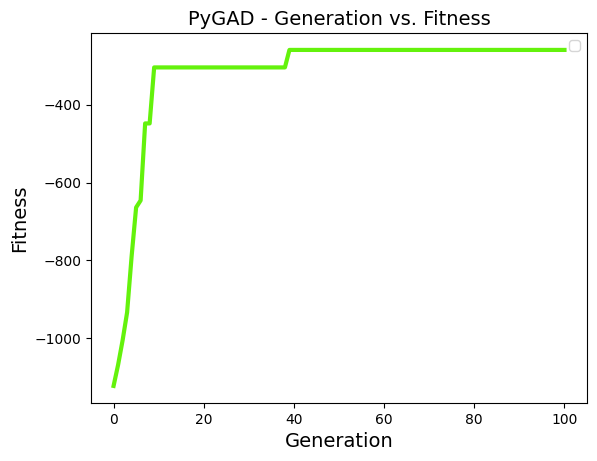

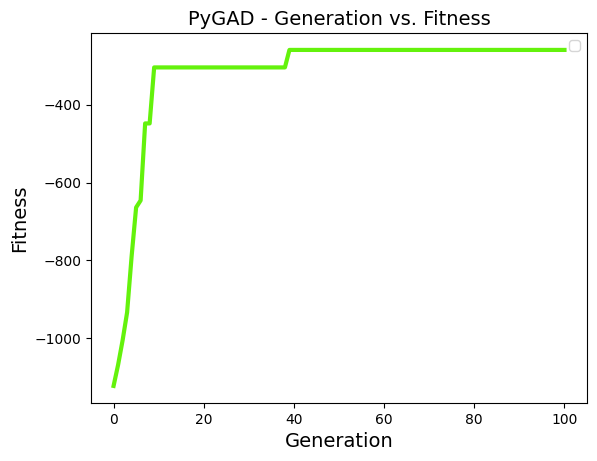

In [56]:
# Run the Genetic Algorithm
ga_instance.run()

# Get the best solution found by GA
best_solution = ga_instance.best_solution()[0]
best_fitness = ga_instance.best_solution()[1]

# Decode and display the best solution
optimized_schedule = decode_solution(best_solution)
print("Optimized Machine Schedule:", optimized_schedule)
print("Best Fitness (Negative Makespan):", best_fitness)

# Plot the fitness over generations
ga_instance.plot_fitness()